In [1]:
import sys

sys.path.append("../")

In [2]:
import cheetah
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from gymnasium import spaces
from gymnasium.wrappers import RescaleAction
from stable_baselines3.common.env_checker import check_env

from compare.github_vanilla.environment import e_trajectory_simENV
from src.environments.awake_e_steering import AwakeESteering
from src.wrappers import RescaleObservation

In [3]:
old_env = e_trajectory_simENV()

new_env = AwakeESteering()
wrapped_new_env = RescaleAction(new_env, -1, 1)
wrapped_new_env = RescaleObservation(
    wrapped_new_env, -1, 1, assumed_space=spaces.Box(-1e-2, 1e-2, shape=(10,))
)

/Users/jankaiser/Documents/DESY/rl4aa24-tutorial/notebooks/../compare/github_vanilla/utils/twissReader.py:433: UserWarning: MISSING FIELD PX IN TWISS INPUT ../src/environments/electron_tt43.out
  twissH, twissV = readTwissFromMADX(filename_awakeElectron)
/Users/jankaiser/Documents/DESY/rl4aa24-tutorial/notebooks/../compare/github_vanilla/utils/twissReader.py:433: UserWarning: MISSING FIELD PY IN TWISS INPUT../src/environments/electron_tt43.out
  twissH, twissV = readTwissFromMADX(filename_awakeElectron)


In [4]:
# check_env(old_env)

In [5]:
check_env(wrapped_new_env)

In [6]:
old_env.action_space

Box(-1.0, 1.0, (10,), float32)

In [7]:
new_env.action_space

Box(-0.0003, 0.0003, (10,), float32)

In [8]:
wrapped_new_env.action_space

Box(-1.0, 1.0, (10,), float32)

In [9]:
old_env.observation_space

Box(-1.0, 1.0, (10,), float32)

In [10]:
new_env.observation_space

Box(-inf, inf, (10,), float32)

In [11]:
wrapped_new_env.observation_space

Box(-inf, inf, (10,), float32)

In [12]:
old_env.reset()

(array([-0.01051199, -0.04636254, -0.0653379 , -0.10603157, -0.1350786 ,
         0.1947172 ,  0.3932248 ,  0.29329905,  0.17629753,  0.09611666],
       dtype=float32),
 {})

In [13]:
new_env.reset()

(array([ 0.00017761,  0.00054606,  0.00103664,  0.00180019,  0.00406427,
        -0.00459401, -0.01035894, -0.0080517 , -0.00519519, -0.00349771],
       dtype=float32),
 {'backend_info': {'incoming_beam': array([1.0000000e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 9.8234415e-04, 1.9646883e-04, 9.8234415e-04,
          1.9646883e-04, 1.0000000e-06, 1.0000000e-06], dtype=float32),
   'quadrupole_settings': array([ -5.085799,   9.504011,  -8.240125, -31.725054,  19.703522,
          -31.725054,  -7.92377 ,  26.87176 ,  -1.07907 ,  16.7789  ,
          -14.029   ], dtype=float32)}})

In [14]:
wrapped_new_env.reset()

(array([-0.01232129, -0.02673686, -0.01965177, -0.04931378, -0.12390304,
         0.11668777,  0.288072  ,  0.23250496,  0.17714477,  0.19092667],
       dtype=float32),
 {'backend_info': {'incoming_beam': array([1.0000000e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 9.8234415e-04, 1.9646883e-04, 9.8234415e-04,
          1.9646883e-04, 1.0000000e-06, 1.0000000e-06], dtype=float32),
   'quadrupole_settings': array([ -5.085799,   9.504011,  -8.240125, -31.725054,  19.703522,
          -31.725054,  -7.92377 ,  26.87176 ,  -1.07907 ,  16.7789  ,
          -14.029   ], dtype=float32)}})

In [15]:
%%timeit
_, _ = old_env.reset()

4.49 µs ± 17 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%%timeit
_, _ = wrapped_new_env.reset()

7.03 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
_, _, _, _, _ = old_env.step(old_env.action_space.sample())

23.1 µs ± 45.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%%timeit
_, _, _, _, _ = wrapped_new_env.step(wrapped_new_env.action_space.sample())

7.14 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


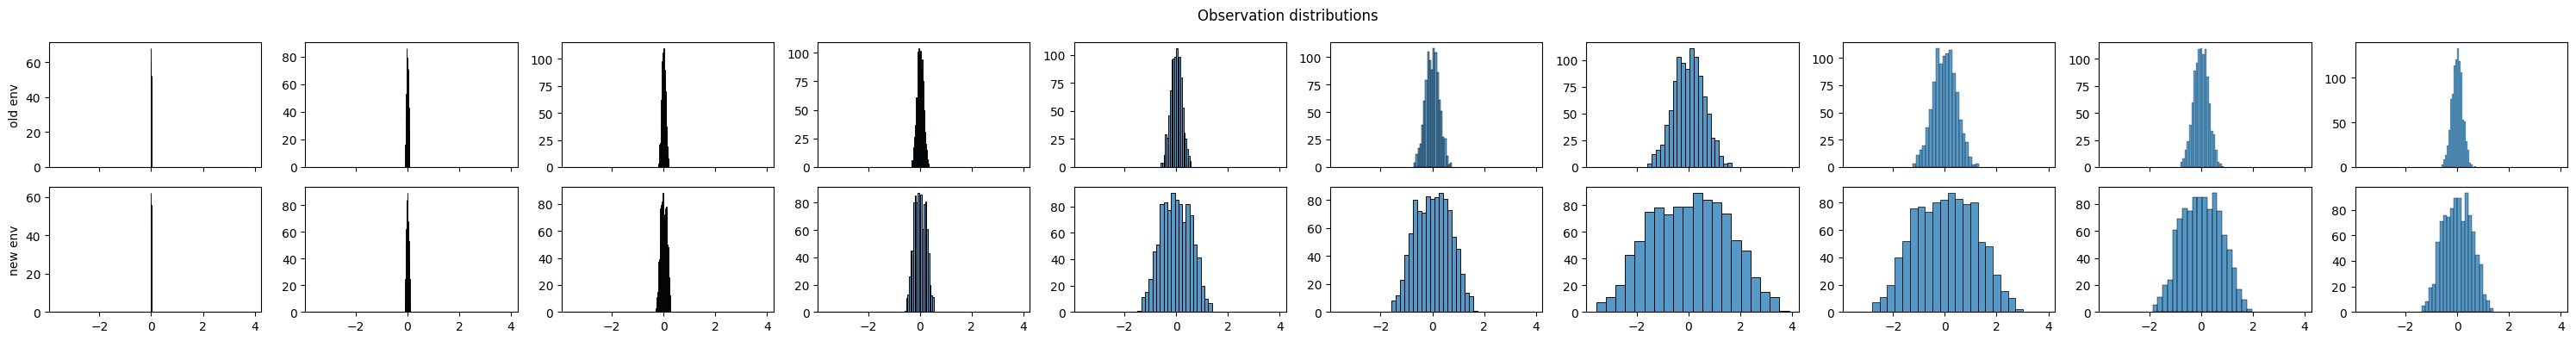

In [19]:
old_env_observations = []
new_env_observations = []
for _ in range(1_000):
    old_env_observations.append(old_env.reset()[0])
    new_env_observations.append(wrapped_new_env.reset()[0])

old_env_observations = np.array(old_env_observations)
new_env_observations = np.array(new_env_observations)

fig, axs = plt.subplots(2, 10, figsize=(30, 4), sharex=True)
for i in range(10):
    sns.histplot(old_env_observations[:, i], ax=axs[0, i], bins=20)
    sns.histplot(new_env_observations[:, i], ax=axs[1, i], bins=20)
    axs[0, i].set_ylabel(None)
    axs[1, i].set_ylabel(None)
axs[0, 0].set_ylabel("old env")
axs[1, 0].set_ylabel("new env")
fig.suptitle("Observation distributions")
plt.tight_layout()
plt.show()

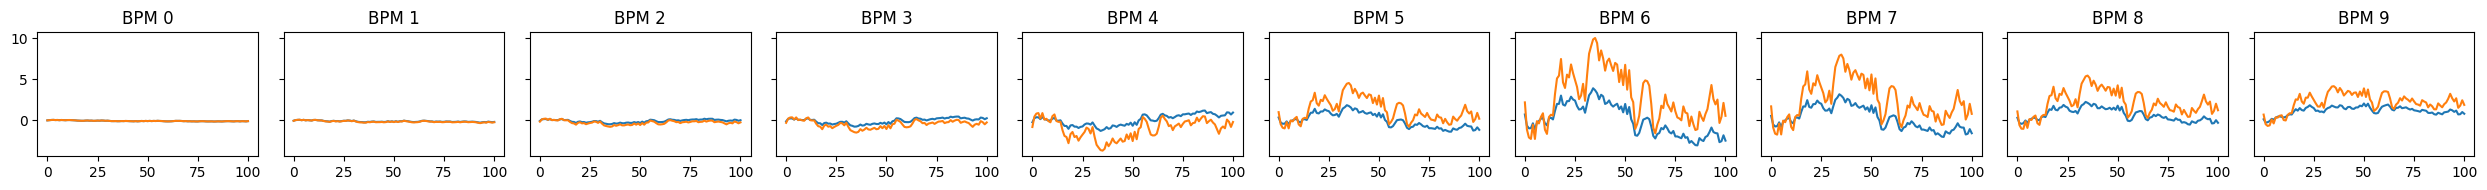

In [20]:
old_observations = []
new_observations = []

observation, info = old_env.reset()
old_observations.append(observation)

observation, info = wrapped_new_env.reset(options={"magnet_init": old_env.kicks_0})
new_observations.append(observation)

for _ in range(100):
    action = old_env.action_space.sample()

    observation, reward, terminated, truncated, info = old_env.step(action)
    old_observations.append(observation)

    observation, reward, terminated, truncated, info = wrapped_new_env.step(action)
    new_observations.append(observation)

old_observations = np.array(old_observations)
new_observations = np.array(new_observations)

fig, axs = plt.subplots(1, 10, figsize=(25, 2), sharex=True, sharey=True)
for i in range(10):
    axs[i].plot(old_observations[:, i], label="old env")
    axs[i].plot(new_observations[:, i], label="new env")
    axs[i].set_title(f"BPM {i}")
plt.tight_layout()
plt.show()

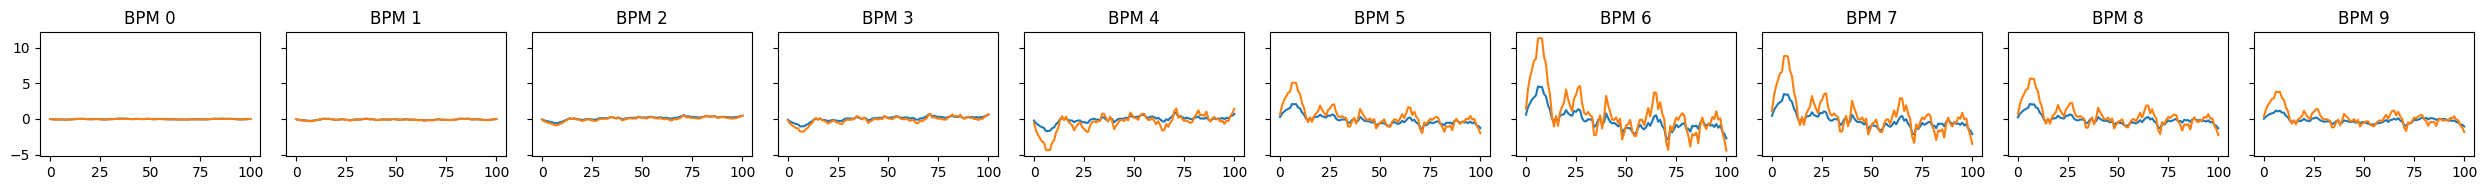

In [21]:
old_observations = []
new_observations = []

observation, info = old_env.reset()
old_observations.append(observation)

observation, info = wrapped_new_env.reset(options={"magnet_init": old_env.kicks_0})
new_observations.append(observation)

for _ in range(100):
    action = wrapped_new_env.action_space.sample()

    observation, reward, terminated, truncated, info = old_env.step(action)
    old_observations.append(observation)

    observation, reward, terminated, truncated, info = wrapped_new_env.step(action)
    new_observations.append(observation)

old_observations = np.array(old_observations)
new_observations = np.array(new_observations)

fig, axs = plt.subplots(1, 10, figsize=(25, 2), sharex=True, sharey=True)
for i in range(10):
    axs[i].plot(old_observations[:, i], label="old env")
    axs[i].plot(new_observations[:, i], label="new env")
    axs[i].set_title(f"BPM {i}")
plt.tight_layout()
plt.show()